In [35]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import time
import onlinelossmax as olm
sys.path.insert(0, './src')
from scipy import stats
import rff, subsample, herding
from kernelgenerator import compute_kernel
%matplotlib inline

class SyntheticTarget(object):
    
    def __init__(self, dist_components=2, dim=2, seed=None):
        if seed is not None:
            np.random.seed(seed)
        self.dist_weights = stats.dirichlet(np.ones(dist_components)*10).rvs().ravel()
        dist_centers = np.random.uniform(-4, 4, size=(dist_components, dim))

        def gen_cov():
            assert(dim == 2)
            rho = np.random.rand()-0.5
            sd = np.random.rand(dim)*0.4+0.5
            L = np.zeros((dim,dim))
            L[0,0] = sd[0]**2
            L[1,1] = sd[1]**2
            L[0,1] = rho*sd.prod()
            return np.dot(L, L.T)

        dist_cov = np.array([gen_cov() for i in xrange(dist_components)])
        self.dist_obj = np.array([stats.multivariate_normal(dist_centers[k], dist_cov[k]) for k in xrange(dist_components)], dtype=object)
        self.dim = dim

    def compute_pdf(self, x):
        return np.sum(self.dist_weights[:,None,None] * np.array([d.pdf(x) for d in self.dist_obj]), 0)

    def draw_sample(self, ns=1):
        component = np.random.multinomial(ns, self.dist_weights) # np.argmin(np.random.rand() > self.dist_weights.cumsum())
        offset = np.concatenate(([0], component.cumsum()[:-1]))
        samples = np.empty((ns,self.dim))
        for c, n in enumerate(component):
            if n > 0:
                samples[offset[c]:offset[c]+n] = self.dist_obj[c].rvs(n) 
        np.random.shuffle(samples)
        return samples

    def draw_sample_slow(self):
        component = np.argmin(np.random.rand() > self.dist_weights.cumsum())
        return self.dist_obj[component].rvs()

    def plot(self):
        delta = 0.1
        boundary = 5
        x = np.arange(-boundary, boundary, delta)
        y = np.arange(-boundary, boundary, delta)
        X, Y = np.meshgrid(x, y)
        Z = np.log(self.compute_pdf(np.concatenate((X[:,:,None],Y[:,:,None]),2)))
        plt.figure()
        contour_levels = np.arange(-9,1)
        CS = plt.contour(X, Y, Z, levels=contour_levels)
        plt.set_cmap('Blues')
        
        
# Change for different sampled target dist
SEED = 666
ex = SyntheticTarget(seed=SEED, dist_components=5)
N = 10000
M = 10
stream = ex.draw_sample(N)
#stream.shape finds the dimensions of the nparray stream
print stream.shape, "=>", M


(10000, 2) => 10


In [36]:
from __future__ import division  #So that when we divide by integers we gegt a float. Eg so that 5/2 = 2.5 not 2.
import numpy as np


def online_loss_reg_max(stream, gamma, new_phi, phis_for_criticisms, full_phi_sum, proto_phi_sum, prototype_indices, criticism_indices, n, M, full_stream_phi, N):
    #ONLINE_LOSS_MAX maximizes L(C) online.
    #Here we are adding x_n and assume that stored_phis and full_phi_sum have been updated to include x_new: the new data point.
    
    criticism_indices = np.hstack((criticism_indices,n-1))
    criticism_kernel_matrix = compute_kernel(stream[criticism_indices], M+1, gamma)
    phis_for_criticisms = np.vstack((phis_for_criticisms,new_phi))
    #print phis_for_criticisms.shape
    
    losses = np.zeros(M+1)
    overall_losses = np.zeros(M+1)
    for l in range(M+1):
        #losses[l] = np.abs((1/n)*sum(kernel_matrix[range(n),criticism_indices[l]]) - (1/M)*sum(kernel_matrix[prototype_indices,criticism_indices[l]]))
        #overall_losses[l] = np.abs((1/N)*sum(kernel_matrix[range(N), criticism_indices[l]]) - (1/M)*sum(kernel_matrix[true_proto_indices, criticism_indices[l]]))
        losses[l] = np.abs((1/n)*np.inner(full_phi_sum, phis_for_criticisms[l,:]) - (1/M)*np.inner(proto_phi_sum, phis_for_criticisms[l,:]))
        #overall_losses[l] = np.abs((1/N)*np.inner(full_stream_phi, phis_for_criticisms[l,:]) - (1/M)*np.inner(proto_phi_sum, phis_for_criticisms[l,:]))
    
    total_loss = sum(losses)
    F = np.zeros(M+1)
    for y in range(M+1):
        #print criticism_kernel_matrix
        mate = criticism_kernel_matrix[np.setdiff1d(range(M+1), y), :][:, np.setdiff1d(range(M+1), y)]
        #print mate.shape
        r = np.log(np.linalg.det(criticism_kernel_matrix[np.setdiff1d(range(M+1), y), :][:, np.setdiff1d(range(M+1), y)]))
        F[y] = total_loss - losses[y] + r
    #print(sum(overall_losses))
    
    idx_to_exclude = np.argmax(F)
    
    criticism_indices = np.delete(criticism_indices, idx_to_exclude)
    phis_for_criticisms = np.delete(phis_for_criticisms, idx_to_exclude, axis=0)
    
    #print(losses)
    #min_loss_idx = np.argmin(losses)
    #min_loss_idx = np.argmin(overall_losses)
    #min_loss = losses[min_loss_idx]
    #new_loss = losses[M]
    #print(min_loss_idx)
    #print(sum(overall_losses))
    #print(sum(losses))

    #if new_F > min_F:
        #print(criticism_indices)
        #criticism_indices = np.delete(criticism_indices, min_F_idx)
        #phis_for_criticisms = np.delete(phis_for_criticisms, (min_F_idx), axis=0)
        #print phis_for_criticisms.shape
        
    #else:
        #criticism_indices = np.delete(criticism_indices, M)
        #phis_for_criticisms = np.delete(phis_for_criticisms, (M), axis=0)
        #print phis_for_criticisms.shape
        
    olm_return = [criticism_indices, phis_for_criticisms]
    return olm_return

In [37]:
#The below generates the function to calculate phi_hat, median_heuristic calcuates a value for gamma.
gamma = rff.median_heuristic(stream[:M])
phi = rff.RFF(500, 2, lengthscale=gamma) 

#kernel_matrix = compute_kernel(stream, N, gamma = 0.029)

#Initialization:
prototype_points = np.array(stream[:M])
criticism_indices = range(M, 2*M)
phis_for_criticisms = phi(np.array(stream[criticism_indices]))

# Compute batch benchmark feature mean
#full_stream_phi = phi(stream).mean(0)
#full_stream_sq_norm = np.sum(full_stream_phi**2,0)

subsampler = subsample.LinearSubsampler(prototype_points, phi, logging=True)
full_stream_phi = sum(phi(stream))

#for i in xrange(2*M, len(stream)):
for i in range(2*M, N):
    if np.mod(i, 5000) == 1:
        print i-1
    subsampler.consider(stream[i])
    prototype_indices = subsampler.which
    is_accepted = subsampler.accepted[-1]
    #print (i+1)*subsampler._full_mean_phi
    #print subsampler.total_sum_test
    
    #prototype_indices = np.asarray([5520, 9233, 8410, 2765 ,5408, 7700 ,6251 ,3124, 3154 ,8664])
    
    if not is_accepted:
        olm_return = online_loss_reg_max(new_phi = phi(stream[i]), phis_for_criticisms = phis_for_criticisms, 
                                         full_phi_sum = subsampler.total_sum_test, 
                                         proto_phi_sum = subsampler.sample_sum_test, 
                                         prototype_indices = prototype_indices, 
                                         criticism_indices = criticism_indices, n = i+1, 
                                         M = M, full_stream_phi = full_stream_phi, N = N,
                                         stream = stream, gamma = gamma)
                                         #kernel_matrix = kernel_matrix)
                                         #true_proto_indices = np.asarray([912, 755, 576, 919 ,962, 902 ,775 ,850 ,906, 948]))
        criticism_indices = olm_return[0]
        #print criticism_indices
        #print criticism_indices
        phis_for_criticisms = olm_return[1]
        
print criticism_indices
print prototype_indices
        
    


5000
[9869 9900 9905 9918 9923 9933 9968 9979 9988 9990]
[9690 7820 7506 9858 9457 7200 5496 8297 7615 5813]


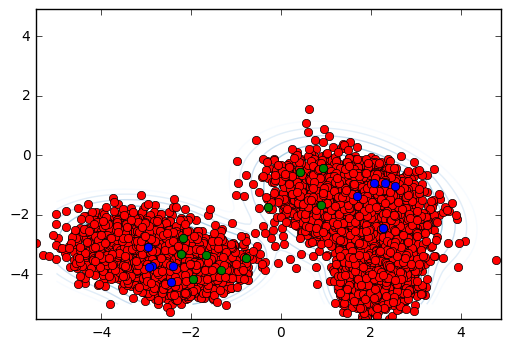

In [38]:
data = stream
ex.plot()
plt.plot(data[:N,0], data[:N,1], 'ro');
plt.plot(data[prototype_indices,0], data[prototype_indices,1], 'bo');
plt.plot(data[criticism_indices,0], data[criticism_indices,1], 'go');

In [6]:
a = np.matrix([[1,2,3],[2,3, 4], [9,3, 6]])